<a href="https://colab.research.google.com/github/kamzam/fml_project_v1.1/blob/master/kz2137_hw2_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2 - Convolutional Neural Nets

In this homework, we will be working with google [colab](https://colab.research.google.com/). Google colab allows you to run a jupyter notebook on google servers using a GPU or TPU. To enable GPU support, make sure to press Runtime -> Change Runtime Type -> GPU. 

## Cats vs dogs classification

To learn about and experiment with convolutional neural nets we will be working on a problem of great importance in computer vision - classifying images of cats and dogs.

The problem is so important that there's even an easter egg in colab: go to Tools -> Settings -> Miscellaneous and enable 'Corgi mode' and 'Kitty mode' to get more cats and dogs to classify when you're tired of coding.



### Getting the data

To get started with the classification, we first need to download and unpack the dataset (note that in jupyter notebooks commands starting with `!` are executed in bash, not in python):

In [19]:
! wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O ./cats_and_dogs_filtered.zip

--2021-03-12 14:14:26--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.73.240, 172.217.5.240, 172.253.62.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.73.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./cats_and_dogs_filtered.zip’

./cats_and_dogs_fil 100%[===================>]  65.43M   124MB/s    in 0.5s    

2021-03-12 14:14:27 (124 MB/s) - ‘./cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [8]:
! unzip cats_and_dogs_filtered.zip 

Archive:  cats_and_dogs_filtered.zip
replace cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: cats_and_dogs_filtered/vectorize.py  
replace cats_and_dogs_filtered/validation/dogs/dog.2127.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
replace cats_and_dogs_filtered/validation/dogs/dog.2126.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
replace cats_and_dogs_filtered/validation/dogs/dog.2125.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
replace cats_and_dogs_filtered/validation/dogs/dog.2124.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
replace cats_and_dogs_filtered/validation/dogs/dog.2123.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

This dataset contains two directories, `train` and `validation`. Both in turn contain two directories with images: `cats` and `dogs`. In `train` we have 1000 images of cats, and another 1000 images of dogs. For `validation`, we have 500 images of each class. Our goal is to implement and train a convolutional neural net to classify these images, i.e. given an image from this dataset, tell if it contains a cat or a dog.



In [9]:
! echo 'Training cats examples:' $(find cats_and_dogs_filtered/train/cats -type f | wc -l)
! echo 'Training dogs examples:' $(find cats_and_dogs_filtered/train/dogs -type f | wc -l)
! echo 'Validation cats examples:' $(find cats_and_dogs_filtered/validation/cats -type f | wc -l)
! echo 'Validation dogs examples:' $(find cats_and_dogs_filtered/validation/dogs -type f | wc -l)

Training cats examples: 1000
Training dogs examples: 1000
Validation cats examples: 500
Validation dogs examples: 500


### Loading the data
 Now that we have the data on our disk, we need to load it so that we can use it to train our model. In Pytorch ecosystem, we use `Dataset` class, documentation for which can be found [here](https://pytorch.org/docs/stable/data.html). 

 In the case of computer vision, the datasets with the folder structure 'label_name/image_file' are very common, and to process those there's already a class `torchvision.datasets.ImageFolder` (documented [here](https://pytorch.org/vision/0.8/datasets.html)). Torchvision is a Pytorch library with many commonly used tools in computer vision.

 Another thing we need from Torchvision library is transforms ([documentation](https://pytorch.org/docs/stable/torchvision/transforms.html)). In computer vision, we very often want to transform the images in certain ways. The most common is normalization. Others include flipping, changing saturation, hue, contrast, rotation, and blurring. 

 Below, we create a training, validation and test sets. We use a few transforms for augmentation on the training set, but we don't use anything but resize and normalization for validation and test. 

In [10]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image # PIL is a library to process images

# These numbers are mean and std values for channels of natural images. 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Inverse transformation: needed for plotting.
unnormalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

train_transforms = transforms.Compose([
                                    transforms.Resize((256, 256)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ColorJitter(hue=.1, saturation=.1, contrast=.1),
                                    transforms.RandomRotation(20, resample=Image.BILINEAR), #interpolation
                                    transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
                                    transforms.ToTensor(),  # convert PIL to Pytorch Tensor
                                    normalize,
                                ])

validation_transforms = transforms.Compose([
                                    transforms.Resize((256, 256)),
                                    transforms.ToTensor(), 
                                    normalize,
                                ])

train_dataset = torchvision.datasets.ImageFolder('./cats_and_dogs_filtered/train', transform=train_transforms)
validation_dataset, test_dataset = torch.utils.data.random_split(torchvision.datasets.ImageFolder('./cats_and_dogs_filtered/validation', transform=validation_transforms), [500, 500], generator=torch.Generator().manual_seed(42))

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


Let's see what one of the images in the dataset looks like (you can run this cell multiple times to see the effects of different augmentations):

torch.Size([3, 256, 256])


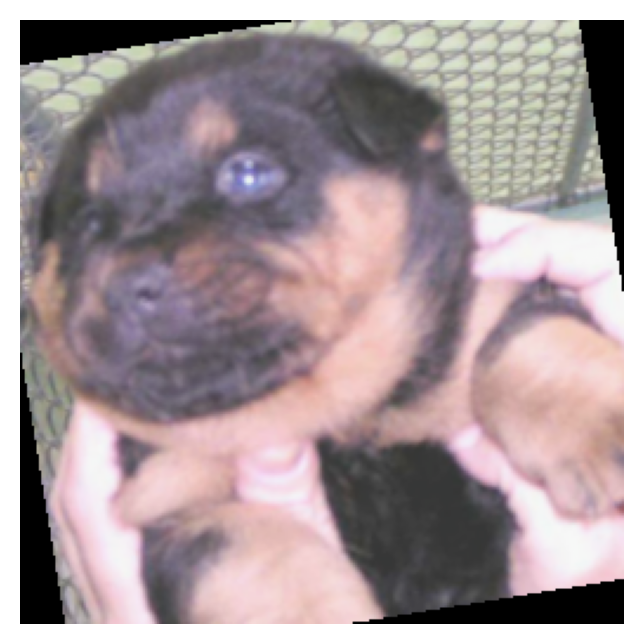

In [11]:
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 200 # change dpi to make plots bigger

def show_normalized_image(img, title=None):
  plt.imshow(unnormalize(img).detach().cpu().permute(1, 2, 0))
  plt.title(title)
  plt.axis('off')

show_normalized_image(train_dataset[1999][0])
print(train_dataset[1003][0].shape)
#plt.imshow(train_dataset[1003][0].detach().cpu().permute(1, 2, 0)) # added self

### Creating the model

Now is the time to create a model. All models in Pytorch are subclassing `torch.nn.Module`, and have to implement `__init__` and `forward` methods. 

Below we provide a simple model skeleton, which you need to expand. The places to put your code are marked with `TODO`. Here, we ask you to implement a convolutional neural network containing the following elements:

* Convolutional layers (at least two)
* Batch Norm
* Non-linearity
* Pooling layers
* A residual connection similar to that of Res-Net
* A fully connected layer

For some examples of how to implement Pytorch models, please refer to our lab notebooks, such as [this one](https://github.com/Atcold/pytorch-Deep-Learning/blob/master/06-convnet.ipynb).

In [13]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F


class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.l1= nn.Linear(input_size*3*BATCH_SIZE, BATCH_SIZE)
        self.l2=nn.Linear(BATCH_SIZE, output_size)
        

    def forward(self, x):
        print("in forward")
        x = x.view(-1, self.input_size*3*BATCH_SIZE)
        print('Forward view ', x.shape)
        x=self.l1(x)
        print('L1 view ', x.shape)
        x=relu(x)
        print('R1 view ', x.shape)
        x=self.l2(x)
        print('L2 view ', x.shape)
        x=relu(x)
        print('R2 view ', x.shape)
        #x= self.network(x)
        x=relu(x)
        print('done forward')
        return x

class CNN(torch.nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*61*61*BATCH_SIZE, BATCH_SIZE) # Dimesion 61 is from 256(input)->252(convoltion) ->126(pooling with kernel 2)->  122 (convoltion)->61 (pooling with kernel 2)
        self.fc2 = nn.Linear(BATCH_SIZE, 2) # Here output size is = 2 since we have 2 classes i.e cat and dog
        self.bn =  nn.BatchNorm2d(n_feature, affine=False)  # the filter size is same in both cases i.e 5x5 hence we only define one instance of Batch Norm
        self.relu = nn.ReLU()
 
    def forward(self, x):
    # TODO
     #print("in forward")
     #print(x.shape)
     x = self.conv1(x)
     x= self.bn(x)
     x = self.relu(x)
     x = F.max_pool2d(x, kernel_size=2)
     x = self.conv2(x)
     x= self.bn(x)
     x = self.relu(x)
     x = F.max_pool2d(x, kernel_size=2)
     #print("Max pool shape" , x.shape)
     x = x.view(-1, self.n_feature*x.shape[2]*x.shape[3]*BATCH_SIZE) # Falttened with value matching input paramters from previous layer
     #print("View shape" , x.shape)
     x = self.fc1(x)
     #print("FC1 shape" , x.shape)
     x = F.relu(x)
     x = self.fc2(x)
     #print("FC2 shape" , x.shape)
     x = F.relu(x)
     #x = F.log_softmax(x, dim=1)
     #print("conv done") 
     return x


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")   # GPU device created for cuda move of models and data 

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

# function to count number of parameters (testing only )
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [15]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 65536).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        print('Data Shape',data.shape, 'Target SHape',target.shape )
        # permute pixels
        data = data.view(-1, 256*256)
        print('Data after view 1', data.shape)
        data = data[:, perm]
        print('Data after view 2', data.shape)
        data = data.view(-1, 1, 256, 256)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=torch.arange(0, 65536).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 256*256)
        data = data[:, perm]
        #print(data.shape)
        data = data.view(-1, 1, 256, 256)
        output = model(data)
        #print(output.shape)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [ ]:
n_hidden = 8 # number of hidden units
n_features = 8 # number of hidden units
input_size  = 256*256   # images are 28x28 pixels
output_size = 2      # there are 2 classes
N_EPOCHS = 5 # TODO
BATCH_SIZE = 400 # TODO

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=4)

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))


model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Training the model

Now we train the model on the dataset. Again, we're providing you with the skeleton with some parts marked as `TODO` to be filled by you.

In [89]:
from tqdm.notebook import tqdm
# importing library
import numpy 


n_hidden = 8 # number of hidden units (testing fc layers)
n_features = 8 # number feature maps
input_size  = 256*256   # images are 28x28 pixels
output_size = 2      # there are 2 classes

#Total training samples = 2000 so we I used a batch sixe of 400 to create 5 epochs
N_EPOCHS = 5 # TODO
BATCH_SIZE = 400 # TODO 


#Test tdqm 
#for i in tqdm(range(int(90))): 
    #pass

def get_loss_and_correct(model, batch, criterion, device):
  # Implement forward pass and loss calculation for one batch.
  # Remember to move the batch to device.
  # 
  #print(batch[0],batch[1])
  perm=torch.arange(0, 65536).long() #256x256
  data = batch[0]
  target = batch[1]
  # send to device
  data, target = data.to(device), target.to(device)  # sending tensors to GPU
  print('Data Shape',data.shape, 'Target SHape',target.shape )
  # permute pixels
  data = data.view(-1, 256*256)
  #print('Data after view 1', data.shape)
  data = data[:, perm]
  #print('Data after view 2', data.shape)
  data = data.view(-1, 1, 256, 256)
  optimizer.zero_grad()
  output = model(data) #Forward pass applied here 

  # Return a tuple:
  # - loss for the batch (Tensor)
  # - number of correctly classified examples in the batch (Tensor)
 

  loss =  criterion(output, target,, reduction='sum')     # Tensor,  criterion will be th loss function passed   
  #loss = F.nll_loss(output, target,, reduction='sum')    # Running Example in backend

  pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
  correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()  # summing the items where pred value is equal to target value. 


  #Sum True Positives and True Negatives, use later once run complete
  #conf_matrix = metrics.confusion_matrix(output, target)
  #print(conf_matrix)
  return (loss,  torch.tensor(correct))
  pass

def step(loss, optimizer):
  # Implement backward pass and update.
  # TODO
  loss.backward()
  optimizer.step()
  pass


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=4)

#n_features = 8 # number of feature maps (defined above on the top )

model = CNN(3 ,n_features,output_size)
model.to(device)
#criterion = None # TODO
criterion = nn.L1Loss() #F.nll_loss()
 
#optimizer = None # TODO
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model)))
model.train()

if torch.cuda.is_available():
  model = model.cuda()
  criterion = criterion.cuda()
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

pbar = tqdm(range(N_EPOCHS))

for i in pbar:
  total_train_loss = 0.0
  total_train_correct = 0.0
  total_validation_loss = 0.0
  total_validation_correct = 0.0

  model.train()

  for batch in tqdm(train_dataloader, leave=False):
    loss, correct = get_loss_and_correct(model, batch, criterion, device)
    step(loss, optimizer)
    total_train_loss += loss.item()
    total_train_correct += correct.item()

  with torch.no_grad():
    for batch in validation_dataloader:
      print("New batch",len(batch[0]))
      loss, correct = get_loss_and_correct(model, batch, criterion, device)
      total_validation_loss += loss.item()
      total_validation_correct += correct.item()

  mean_train_loss = total_train_loss / len(train_dataset)
  train_accuracy = total_train_correct / len(train_dataset)

  mean_validation_loss = total_validation_loss / len(validation_dataset)
  validation_accuracy = total_validation_correct / len(validation_dataset)

  train_losses.append(mean_train_loss)
  validation_losses.append(mean_validation_loss)

  train_accuracies.append(train_accuracy)
  validation_accuracies.append(validation_accuracy)

  pbar.set_postfix({'train_loss': mean_train_loss, 'validation_loss': mean_validation_loss, 'train_accuracy': train_accuracy, 'validation_accuracy': validation_accuracy})


Number of parameters: 7700


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


in forward
torch.Size([64, 3, 256, 256])
Max pool shape torch.Size([64, 6, 61, 61])
View shape torch.Size([14884, 96])
FC1 shape torch.Size([14884, 64])
FC2 shape torch.Size([14884, 2])
conv done
torch.Size([14884, 2])
in forward
torch.Size([64, 3, 256, 256])
Max pool shape torch.Size([64, 6, 61, 61])
View shape torch.Size([14884, 96])
FC1 shape torch.Size([14884, 64])
FC2 shape torch.Size([14884, 2])
conv done
torch.Size([14884, 2])
in forward
torch.Size([64, 3, 256, 256])
Max pool shape torch.Size([64, 6, 61, 61])
View shape torch.Size([14884, 96])
FC1 shape torch.Size([14884, 64])
FC2 shape torch.Size([14884, 2])
conv done
torch.Size([14884, 2])
in forward
torch.Size([64, 3, 256, 256])
Max pool shape torch.Size([64, 6, 61, 61])
View shape torch.Size([14884, 96])
FC1 shape torch.Size([14884, 64])
FC2 shape torch.Size([14884, 2])
conv done
torch.Size([14884, 2])
in forward
torch.Size([64, 3, 256, 256])
Max pool shape torch.Size([64, 6, 61, 61])
View shape torch.Size([14884, 96])
FC1 s

RuntimeError: ignored

Now that the model is trained, we want to visualize the training and validation losses and accuracies:

In [ ]:
plt.figure(dpi=200)

plt.subplot(121)
plt.plot(train_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses')
plt.legend()

plt.subplot(122)
plt.plot(train_accuracies, label='train')
plt.plot(validation_accuracies, label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('Accuracies')

plt.tight_layout()

Now, change your model to achieve at least 75% accuracy on validation set. You can change the model you've implemented, the optimizer, and the augmentations. 

Looking at the loss and accuracy plots, can you see if your model overfits the trainig set? Why?

Answer:
`put your answer here`

### Testing the model

Now, use the `test_dataset` to get the final accuracy of your model. Visualize some correctly and incorrectly classified examples.

In [ ]:
# TODO
# 1. Calculate and show the test_dataset accuracy of your model.
label_classes = 2
confusion_matrix = torch.zeros(label_classes, label_classes)

# We will update the confusion matrix every time test is called for a atch and so we will get the overall performance on the test/validation data.

def test(model, perm=torch.arange(0, 65536).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in validation_dataloader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 256*256)
        data = data[:, perm]
        #print(data.shape)
        data = data.view(-1, 1, 256, 256)
        output = model(data)
        #print(output.shape)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

        #Visuliazing using a confusion matrix
        for t, p in zip(target.view(-1), pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        



    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

# 2. Visualize some correctly and incorrectly classified examples.

print(confusion_matrix)



### Visualizing filters

In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's get some image.

In [ ]:
image = validation_dataset[10][0]
show_normalized_image(image)

Now, we are going to 'clip' our model at different points to get different intermediate representation. 
Clip your model at two or three different points and plot the filters output.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 4 layers, you can do:

```
clipped = nn.Sequential(
    *list(model.children()[:4])
)
intermediate_output = clipped(input)
```



In [ ]:
import math

def plot_intermediate_output(result, title):
  """ Plots the intermediate output of shape
      N_FILTERS x H x W
  """
  n_filters = result.shape[1]
  N = int(math.sqrt(n_filters))
  M = (n_filters + N - 1) // N
  assert N * M >= n_filters
  
  fig, axs = plt.subplots(N, M)
  fig.suptitle(title)
  
  for i in range(N):
    for j in range(M):
      if i*N + j < n_filters:
        axs[i][j].imshow(result[0, i*N + j].cpu().detach())
        axs[i][j].axis('off')

# TODO: 
# pick a few intermediate representations from your network and plot them using 
# the provided function.

What can you say about those filters? What features are they focusing on?

Anwer: `Your answer here`